Đây là code đơn giản cho nhiệm vụ Titanic - Machine Learning from Disaster https://www.kaggle.com/competitions/titanic 

![Titanic Movie](titanic.jpg)

# 1.Load data

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train_data = pd.read_csv('/kaggle/input/titanic/train.csv', index_col = "PassengerId")
test_data = pd.read_csv("/kaggle/input/titanic/test.csv", index_col = "PassengerId")
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


Gộp dữ liệu

In [3]:
test_data.insert(0, 'Survived', np.nan) 
data = np.concatenate([train_data, test_data], axis = 0)         
data_df = pd.DataFrame(data, columns = train_data.columns, index = range(1,len(data)+1)) 

## Exploratory Data Analysis (EDA)
* Categorical: Pclass, Sex, SibSp, Parch, Embarked, Survived
* Numerical : Age, Fare

In [4]:
train_data.Survived = train_data.Survived.astype("category")      #chuyển Survived thành loại Categorical
converted_features = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']

def convert_cat(df, features):         #hàm chuyển features thành loại Categorical
    for feature in features:
        df[feature] = df[feature].astype('category')

convert_cat(train_data, converted_features)
convert_cat(test_data, converted_features)

Phân tích dữ liệu **Survived** và các giá trị khác tương tự

In [5]:
train_data['Survived'].value_counts(normalize=True).to_frame() 

,proportion
Survived,
0,0.616162
1,0.383838


Có thể vẽ đồ thij cho trực quan

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


<Axes: xlabel='Sex', ylabel='count'>

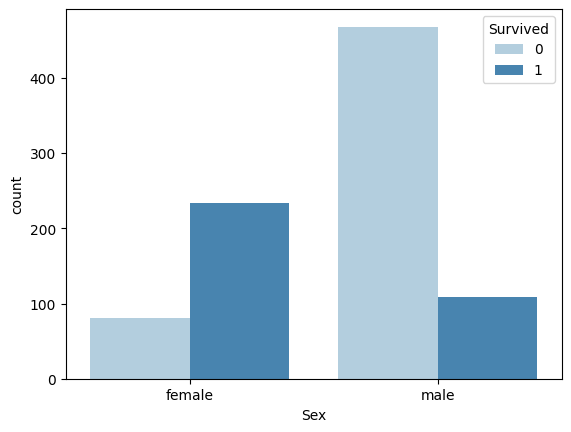

In [6]:
sns.countplot(data = train_data, x = 'Sex', hue = 'Survived', palette = 'Blues') 

# 2.Feature Engineering vs Data Wrangling

## Feature Engineering

* Tạo **Title** từ **Name**

In [7]:
import re
def extract_title(name):
    p = re.compile(r",([\w\s]+)\.")        
    return p.search(name).groups(1)[0].strip()

train_data['Title'] = train_data['Name'].apply(lambda name: extract_title(name))      
train_data['Title'].value_counts()

Title
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: count, dtype: int64

In [8]:
test_data['Title'] = test_data['Name'].apply(lambda name: extract_title(name))

Nhóm các **Title** hiếm gặp lại

In [9]:
def group_title(title):        #Hàm nhóm title
    if title in ['Mr', 'Mrs', 'Miss', 'Master']:
        return title
    elif title == 'Ms':
        return 'Miss'
    else:
        return 'Others'

train_data['Title'] = train_data['Title'].apply(lambda title: group_title(title))
test_data['Title'] = test_data['Title'].apply(lambda title: group_title(title))

* Tạo biến **Family_Survival**

In [10]:
data_df['Last_Name'] = data_df['Name'].apply(lambda x: str.split(x, ',')[0])   
DEFAULT_SURVIVAL_VALUE = 0.5

for grp, grp_df in data_df.groupby(['Last_Name', 'Fare']):       # Nhóm theo Last_Name và Fare: vì gia đình thường có họ giống nhau và giá vé giống 
    if len(grp_df) != 1:                                    
        for ind, row in grp_df.iterrows():                    
            smax = grp_df.drop(ind)['Survived'].max()         
            smin = grp_df.drop(ind)['Survived'].min()         
            index = ind
            if (smax == 1.0):
                data_df.loc[data_df.index == index, 'Family_Survival'] = 1        
            elif (smin == 0.0):
                data_df.loc[data_df.index == index, 'Family_Survival'] = 0  

In [11]:
for _, grp_df in data_df.groupby('Ticket'):        #Nhóm theo số vé(đi cùng hay mua cùng vé)
    if len(grp_df) != 1:
        for ind, row in grp_df.iterrows():
            if(row['Family_Survival'] == 0)| (row['Family_Survival'] == 0.5):
                smax = grp_df.drop(ind)['Survived'].max()
                smin = grp_df.drop(ind)['Survived'].min()
                index = ind
                if smax == 1.0:
                    data_df.loc[data_df.index == index, 'Family_Survival'] = 1
                elif smin == 0.0:
                    data_df.loc[data_df.index == index, 'Family_Survival'] = 0

In [12]:
train_data['Family_Survival'] = data_df['Family_Survival'][:891]       
test_data['Family_Survival'] = data_df['Family_Survival'][891:]

* Tạo **Family_Size** = **SibSp** + **Parch** + 1 Biểu diễn số người trong gia đình

In [13]:
train_data['Family_Size'] = train_data['SibSp'].astype(int) + train_data['Parch'].astype(int) +1
test_data['Family_Size'] = test_data['SibSp'].astype(int) + test_data['Parch'].astype(int) + 1

<Axes: xlabel='Family_Size', ylabel='count'>

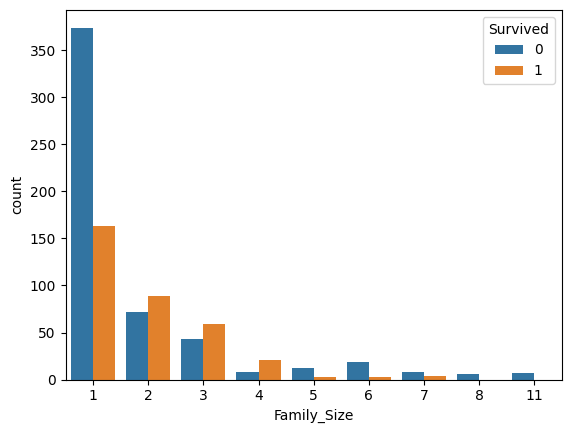

In [14]:
sns.countplot(data = train_data, x = 'Family_Size', hue = 'Survived')

In [15]:
train_data['Family_Cat'] = pd.cut(train_data['Family_Size'], bins = [0,1,4,6,20])
test_data['Family_Cat'] = pd.cut(test_data['Family_Size'], bins = [0,1,4,6,20])

* Tạo biến **Deck** từ **Cabin**

Những người thuộc cùng khoang có điều kiện thoát thân như nhau, nên ta nghĩ đến tạo đẵc trưng Deck

In [16]:
def convert_cabin(df):      
    df['Deck'] = df['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')   #chữ cái đầu tiên của Cabin
    
    df['Deck'] = df['Deck'].replace(['A','B','C','T'],'ABC')      
    df['Deck'] = df['Deck'].replace(['D', 'E'], 'DE')
    df['Deck'] = df['Deck'].replace(['F','G'], 'FG')
    
convert_cabin(train_data)
convert_cabin(test_data)
train_data['Deck']

PassengerId
1        M
2      ABC
3        M
4      ABC
5        M
      ... 
887      M
888    ABC
889      M
890    ABC
891      M
Name: Deck, Length: 891, dtype: object

## Data Wrangling

In [17]:
num_features = ['Age', 'Fare']
cat_features = ['Sex', 'Pclass', 'Embarked', 'Title','Family_Cat', 'Family_Survival', 'Deck']
feature_cols = num_features + cat_features
print(feature_cols)

['Age', 'Fare', 'Sex', 'Pclass', 'Embarked', 'Title', 'Family_Cat', 'Family_Survival', 'Deck']


In [18]:
convert_cat(train_data, cat_features)
convert_cat(test_data, cat_features)

In [19]:
def display_missing(df, feature_cols):
    n_rows = df.shape[0]
    for col in feature_cols:
        missing_count = df[col].isnull().sum()
        if missing_count > 0:
            print(f"{col} has {missing_count*100/n_rows:.2f}% missing values.")

display_missing(train_data, feature_cols)
display_missing(test_data, feature_cols)

Age has 19.87% missing values.
Embarked has 0.22% missing values.
Family_Survival has 68.35% missing values.
Age has 20.57% missing values.
Fare has 0.24% missing values.
Family_Survival has 66.99% missing values.


Missing value **Age**

In [20]:
train_data['Age'] = train_data.groupby(['Sex','Pclass'])['Age'].transform(lambda x : x.fillna(x.median()))
test_data['Age'] = test_data.groupby(['Sex','Pclass'])['Age'].transform(lambda x : x.fillna(x.median()))

/tmp/ipykernel_124/3093257334.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_data['Age'] = train_data.groupby(['Sex','Pclass'])['Age'].transform(lambda x : x.fillna(x.median()))
/tmp/ipykernel_124/3093257334.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  test_data['Age'] = test_data.groupby(['Sex','Pclass'])['Age'].transform(lambda x : x.fillna(x.median()))


# 3.Model

In [21]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [22]:
X = train_data[feature_cols]
y = train_data['Survived']
X_test = test_data[feature_cols]

In [23]:
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy = 'median')),
    ('scaler', StandardScaler()),
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown = 'ignore')),
])

In [24]:
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)
])
preprocessor.fit(X)
X = preprocessor.transform(X)
X_test = preprocessor.transform(X_test)

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier,StackingClassifier

In [26]:
KNN = KNeighborsClassifier(leaf_size=26, metric='minkowski',n_jobs=1, n_neighbors=6, p=2)
RFC = RandomForestClassifier(n_estimators = 100, max_depth = 5, random_state=1)

classifiers = [('RFC', RFC), ('KNN', KNN)]
vot=VotingClassifier(estimators=classifiers, voting='hard')        #Dùng voting để quyết định (mỗi model là 1 phiếu bầu)
vot.fit(X,y) 
y_pred = vot.predict(X_test)

# 5.Output

In [27]:
output = pd.DataFrame({'PassengerId': test_data.index, 'Survived': y_pred})
output.to_csv('gender_submission.csv', index = False)

In [28]:
output

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
